# Predicting ADR Fluctuations with ARIMA

In this example, the ARIMA model is used to forecast ADR on the hotel cancellation dataset as provided by Antonio, Almeida and Nunes (2019). Attributions provided below.

#### Attributions

The below code uses the [pmdarima](https://github.com/alkaline-ml/pmdarima) library (Copyright (c) 2017 Taylor G Smith) in executing the below examples, as provided under the MIT License.

Modifications have been made where appropriate for conducting analysis on the tseries specific to this example.

The copyright and permission notices are made available below:

Copyright (c) 2017 Taylor G Smith

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

The data used in this example is sourced from [Antonio, Almeida and Nunes (2019)](https://www.sciencedirect.com/science/article/pii/S2352340918315191).

The below work and findings are not endorsed by the original authors in any way.

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
from sklearn.metrics import mean_squared_error
import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose


dtypes = {
        'IsCanceled':                                    'float64',
        'LeadTime':                                          'float64',
        'StaysInWeekendNights':                                     'float64',
        'StaysInWeekNights':                                     'float64',
        'Adults':                            'float64',
        'Children':                            'float64',
        'Babies':                                  'float64',
        'Meal':                                    'category',
        'Country':                                               'category',
        'MarketSegment':                                    'category',
        'DistributionChannel':                                       'category',
        'IsRepeatedGuest':                               'float64',
        'PreviousCancellations':                                    'float64',
        'PreviousBookingsNotCanceled':                          'float64',
        'ReservedRoomType':                                             'category',
        'AssignedRoomType':                                            'category',
        'BookingChanges':                                                'float64',
        'DepositType':                                              'category',
        'Agent':                                              'category',
        'Company':                                 'category',
        'DaysInWaitingList':                                           'float64',
        'CustomerType':                                           'category',
        'ADR':                                          'float64',
        'RequiredCarParkingSpaces':                                      'float64',
        'TotalOfSpecialRequests':                                              'float64',
        'ReservationStatus':                                                'category'
        }

In [2]:
train_df = pd.read_csv("H1.csv", dtype=dtypes, converters={'ArrivalDateWeekNumber': '{:0>2}'.format})

In [3]:
a=train_df.head()
b=train_df
b
c=b.sort_values(['ArrivalDateYear','ArrivalDateWeekNumber'], ascending=True)
c=pd.DataFrame(c)
c
type(c)

pandas.core.frame.DataFrame

In [4]:
from pandas import DataFrame  

df = DataFrame(c, columns= ['ArrivalDateYear', 'ArrivalDateWeekNumber']) 
df

,ArrivalDateYear,ArrivalDateWeekNumber
0,2015,27
1,2015,27
2,2015,27
3,2015,27
4,2015,27
...,...,...
40055,2017,35
40056,2017,35
40057,2017,35
40058,2017,35


In [5]:
# https://datatofish.com/concatenate-values-python/

df1 = df['ArrivalDateYear'].map(str) + df['ArrivalDateWeekNumber'].map(str)
print (df1)
df1=pd.DataFrame(df1)

0        201527
1        201527
2        201527
3        201527
4        201527
          ...  
40055    201735
40056    201735
40057    201735
40058    201735
40059    201735
Length: 40060, dtype: object


In [6]:
df2 = DataFrame(c, columns= ['ADR']) 
df2

,ADR
0,0.00
1,0.00
2,75.00
3,75.00
4,98.00
...,...
40055,89.75
40056,202.27
40057,153.57
40058,112.80


In [7]:
type(df1)

pandas.core.frame.DataFrame

In [8]:
df3=pd.concat([df1, df2], axis = 1)
df3
df3.columns = ['FullDate', 'ADR']

In [9]:
df3
df3.sort_values(['FullDate','ADR'], ascending=True)

,FullDate,ADR
0,201527,0.00
1,201527,0.00
125,201527,0.00
14463,201527,4.00
81,201527,55.68
...,...,...
13770,201735,328.00
13745,201735,341.00
39847,201735,344.67
39870,201735,351.00


In [10]:
df4 = df3.groupby('FullDate').agg("mean")
df4
df4.sort_values(['FullDate'], ascending=True)

,ADR
FullDate,
201527,100.099096
201528,110.399188
201529,128.112023
201530,140.592271
201531,145.563833
...,...
201731,208.712512
201732,211.528351
201733,211.162040


In [11]:
tseries=df4['ADR']
tseries

FullDate
201527    100.099096
201528    110.399188
201529    128.112023
201530    140.592271
201531    145.563833
             ...    
201731    208.712512
201732    211.528351
201733    211.162040
201734    210.284883
201735    186.204007
Name: ADR, Length: 115, dtype: float64

In [12]:
len(tseries)

115

/home/michael/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  This is separate from the ipykernel package so we can avoid doing imports until


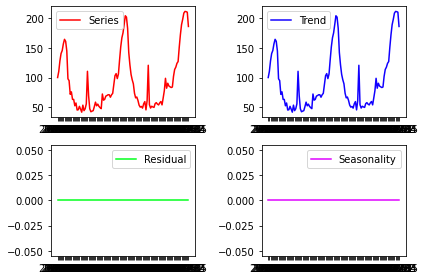

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition=seasonal_decompose(tseries, model='additive', freq=1)
trend=decomposition.trend
seasonal=decomposition.seasonal
residual=decomposition.resid
plt.subplot(221)
plt.plot(tseries,color='#ff0000', label='Series')
plt.legend(loc='best')
plt.subplot(222)
plt.plot(trend,color='#1100ff', label='Trend')
plt.legend(loc='best')
plt.tight_layout()
plt.subplot(223)
plt.plot(residual,color='#00ff1a', label='Residual')
plt.legend(loc='best')
plt.tight_layout()
plt.subplot(224)
plt.plot(seasonal,color='#de00ff', label='Seasonality')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

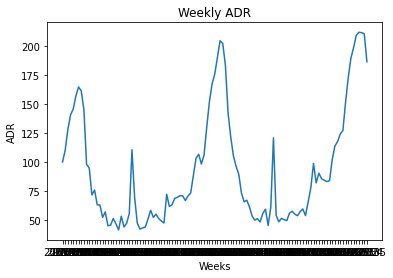

In [14]:
plt.plot(tseries)
plt.xlabel('Weeks')
plt.ylabel('ADR')
plt.title("Weekly ADR")
plt.show()

In [15]:
train_df=tseries[:100]
train_df

FullDate
201527    100.099096
201528    110.399188
201529    128.112023
201530    140.592271
201531    145.563833
             ...    
201716     82.126727
201717     90.483817
201718     85.819405
201719     84.468191
201720     83.256215
Name: ADR, Length: 100, dtype: float64

In [16]:
#Dickey-Fuller Test
result = ts.adfuller(train_df, 1)
result

(-2.0375817419960027,
 0.2703416972640089,
 0,
 99,
 {'1%': -3.498198082189098,
  '5%': -2.891208211860468,
  '10%': -2.5825959973472097},
 824.8815034947377)

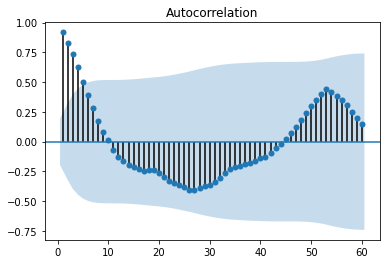

In [17]:
plot_acf(train_df, lags=60, zero=False);

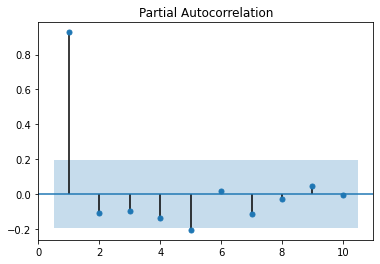

In [18]:
plot_pacf(train_df, lags=10, zero=False);

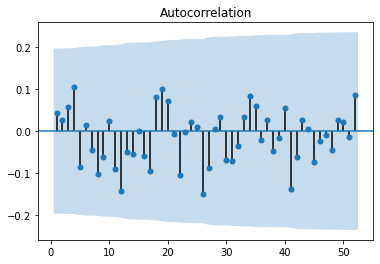

In [19]:
plot_acf(np.diff(train_df, 1), lags=52, zero=False);

In [20]:
test_df=tseries[100:115]
test_df

FullDate
201721     84.123041
201722    102.084528
201723    113.748240
201724    117.552185
201725    124.058338
201726    127.028653
201727    151.235690
201728    172.268659
201729    189.168320
201730    198.222685
201731    208.712512
201732    211.528351
201733    211.162040
201734    210.284883
201735    186.204007
Name: ADR, dtype: float64

In [21]:
window_size = 7

numbers_series = pd.Series(train_df)
windows = numbers_series.rolling(window_size)
moving_averages = windows.mean()

moving_averages_list = moving_averages.tolist()
ts7 = moving_averages_list[window_size - 1:]
ts7=np.array(ts7)
print(ts7)

[135.16469009 143.88383128 148.82684091 144.52656989 138.00091992
 127.4676651  115.91011837 101.44512787  87.45774132  74.24848527
  68.42032915  61.34227389  57.62526368  54.13965709  51.80284518
  48.73610978  48.88183568  47.0396352   47.33794121  48.76809326
  57.2045646   60.45018188  61.27578239  59.68885547  59.57120736
  59.11523238  58.43425135  51.00668662  48.55758438  49.66876656
  50.97204427  51.80658196  52.29532567  55.33613859  55.81288034
  57.35411449  59.27445025  61.88007505  64.99429173  68.33255966
  67.56417689  68.85652859  70.30988407  73.13536282  77.91811464
  83.00410662  86.90144829  92.48455708 100.87696041 112.05814739
 123.27475946 133.58737251 145.44206408 160.5663819  174.26606897
 181.8861418  180.54575244 174.03218483 164.0231715  150.68173432
 134.30966849 115.98494964  99.23300673  88.5139997   79.9648153
  72.57042528  65.98222939  60.5251169   56.94173092  55.51558132
  54.41318825  52.1258276   53.20796116  63.29021148  63.71226676
  63.731450

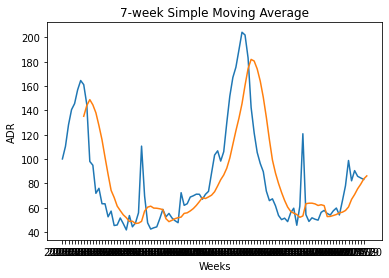

In [22]:
n1=math.nan
n7=np.array([n1,n1,n1,n1,n1,n1,n1])
ts7=np.concatenate([n7,ts7])
plt.plot(train_df)
plt.plot(ts7)
plt.xlabel('Weeks')
plt.ylabel('ADR')
plt.title("7-week Simple Moving Average")
plt.show()

In [23]:
Arima_model=pm.auto_arima(train_df, start_p=0, start_q=0, max_p=10, max_q=10, start_P=0, start_Q=0, max_P=10, max_Q=10, m=52, stepwise=True, seasonal=True, information_criterion='aic', trace=True, d=1, D=1, error_action='warn', suppress_warnings=True, random_state = 20, n_fits=30)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=422.399, Time=0.32 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=inf, Time=21.87 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=inf, Time=48.20 sec
 ARIMA(0,1,0)(1,1,0)[52]             : AIC=inf, Time=40.99 sec
 ARIMA(0,1,0)(0,1,1)[52]             : AIC=inf, Time=38.19 sec
 ARIMA(0,1,0)(1,1,1)[52]             : AIC=inf, Time=39.33 sec
 ARIMA(1,1,0)(0,1,0)[52]             : AIC=414.708, Time=0.95 sec
 ARIMA(1,1,0)(0,1,1)[52]             : AIC=inf, Time=47.51 sec
 ARIMA(1,1,0)(1,1,1)[52]             : AIC=inf, Time=59.30 sec
 ARIMA(2,1,0)(0,1,0)[52]             : AIC=413.878, Time=1.86 sec
 ARIMA(2,1,0)(1,1,0)[52]             : AIC=inf, Time=59.96 sec
 ARIMA(2,1,0)(0,1,1)[52]             : AIC=inf, Time=60.34 sec
 ARIMA(2,1,0)(1,1,1)[52]             : AIC=inf, Time=77.60 sec
 ARIMA(3,1,0)(0,1,0)[52]             : AIC=414.514, Time=2.05 sec
 ARIMA(2,1,1)(0,1,0)[52]             : AIC=415.165, Time=3.74 s

In [24]:
predictions=pd.DataFrame(Arima_model.predict(n_periods=15), index=test_df)
predictions=np.array(predictions)

In [25]:
predictions=predictions.reshape(15,-1)
predictions

array([[ 88.0971519 ],
       [103.18056307],
       [117.93678827],
       [121.38546969],
       [112.9812769 ],
       [120.69309927],
       [144.4014371 ],
       [166.36546077],
       [181.69684755],
       [190.12507961],
       [204.36831063],
       [218.85150166],
       [216.59090879],
       [197.74194692],
       [156.98273524]])

In [26]:
len(predictions)

15

In [27]:
predictions

array([[ 88.0971519 ],
       [103.18056307],
       [117.93678827],
       [121.38546969],
       [112.9812769 ],
       [120.69309927],
       [144.4014371 ],
       [166.36546077],
       [181.69684755],
       [190.12507961],
       [204.36831063],
       [218.85150166],
       [216.59090879],
       [197.74194692],
       [156.98273524]])

In [28]:
len(predictions)

15

In [29]:
len(test_df)

15

In [30]:
mse = mean_squared_error(test_df, predictions)
rmse = math.sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 10.093574


In [31]:
np.mean(test_df)

160.492142162915

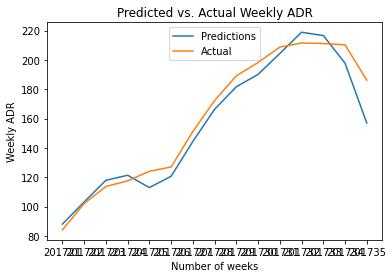

In [32]:
predictons, =plt.plot(predictions, label='Predictions')
actual, =plt.plot(test_df, label='Actual')
plt.xlabel('Number of weeks')
plt.ylabel('Weekly ADR')
plt.title("Predicted vs. Actual Weekly ADR")
plt.legend(loc = 'upper center')
plt.show()